In [56]:
%run "/home/usriniva/uller_modified/discrete_time/Hanna_simu/simulation/impport_packages.ipynb"    #import all necessary packages - numpy, pandas etc
%run "/home/usriniva/uller_modified/discrete_time/Hanna_simu/simulation/simulation_class.ipynb"    #import all necessary packages - numpy, pandas etc
%run "/home/usriniva/uller_modified/discrete_time/Hanna_simu/simulation/create_world.ipynb"

### Reformulation

- Define the **maternal deviation**:


##### $\delta_t$= Phenotype of the mother - Genetic contribution of mother
##### $\delta_t$ = $P_{t-1} - G_{t-1}$

so that the phenotype is the sum of the genetic component of the current generation and maternal deviation from its phenotype:

$$
P = G_t + \omega * \delta_t + \varepsilon_{d}
$$

- We also separate mutation-related noise $\varepsilon_{m}$ from parental phenotype inheritance noise $\varepsilon_{epi}$.  
- We define a evolvable 'weight' term $\omega$: determines how much importance to give each term of the equation
- We also add developmental noise: purely environmental noise in teh form of  $\varepsilon_{d}$


The full new formulation becomes:

$$
Z' = (G_t + \varepsilon_{m}) + (\omega + \varepsilon_{epi})*(\delta_t) +  \varepsilon_{d}
$$

---

In [62]:
def run_simulation(args):
    env_param_space, popsize, maxgen, dims, N, mutsize, mutrate, epsilon, nof_dimensions, only_genetics = args
    
    rho_m_alpha_beta = env_param_space[0:4]
    env_states = env_param_space[4:]

    meanw = np.zeros(maxgen)
    meanmemory_g = np.zeros(maxgen)
    meanmemory_p= np.zeros(maxgen)
    meanneutral_g = np.zeros(maxgen)
    meanneutral_p = np.zeros(maxgen)
    mean_gen = np.zeros(maxgen)
    
    for t in range(0, (maxgen-1)):
        #if t%10 == 0:
        #    print(t)
        for d in range(0, nof_dimensions):
            N[:,dims['dev'][d]] = N[:,dims['pheno'][d]] - env_states[t]
            
        dev_combined = np.sqrt(np.sum(N[:,dims['dev']]**2, axis =1))     
        W = np.exp((-dev_combined**2)/ (2))
        
        
        meanw[t] = np.mean(W)    
        
        meanmemory_g[t] = np.mean(N[:, dims['memory']])  # the actual memory
        meanmemory_p[t] = np.mean(1/(1 + np.exp(-N[:,dims['memory']]))) #with the logistc correction
        
        meanneutral_g[t] = np.mean(N[:,dims['neutral']])
        meanneutral_p[t] = np.mean(1/(1 + np.exp(-N[:,dims['neutral']])))
        mean_gen[t] = np.mean(N[:,dims['geno']])
        
        
        #current gen offspring (the cube gets stored here per gen)
        
        offspring = np.zeros((popsize, dims['total_layers'])) # empty 3D matrix with dimensions of the cube
        
        #sample offspring for each scenario weighted by fitness
        
        
        parents_idx = np.random.choice(popsize, size=popsize, p = (W/np.sum(W)) )#pick #popsize sized random numbers
        offspring[:,:] = N[parents_idx, :] #similar to how it works in matlab
        
        mutate_memories = np.random.uniform(low=0, high=1, size= popsize) < mutrate[0]
        #mutate_neutral = np.random.uniform(low=0, high=1, size=popsize) < mutrate[0]
        mutate_geno = np.random.uniform(low=0, high=1, size=(popsize, nof_dimensions)) < mutrate[1]
        
        # adding a mutation of size mutsize[1], rate mutate_memories, to the epi-memory
        # the epignetic memory evolves; 
        
        offspring[:,dims['memory']] = (
                                offspring[:,dims['memory']] 
                                + mutate_memories * np.random.normal(0, mutsize[0], popsize)
        )
        
        # adding a mutation of size mutsize[1] (epi-mutation size), rate mutate_memories, to the neutral phenotype
        # the neutral trait recieves random mutation but is not implemented in the calculation for fitness; so is evolving neutrally
        offspring[:,dims['neutral']] = (
                                offspring[:,dims['neutral']]  
                                + mutate_memories * np.random.normal(0, mutsize[0], popsize)
        ) 
        
        # adding a mutation of size mutsize[2] (genetic mutation size), rate mutate_memories, to the genotype

        offspring[:,dims['geno']] = (
                            offspring[:,dims['geno']] 
                            + mutate_geno * np.random.normal(0, mutsize[1], size=(popsize, nof_dimensions) )
        )
        
        if only_genetics :
            if t % 10000 == 0:
                print(f"Gen {t}: Running ONLY genetics mode")
            
            for i in range(0, nof_dimensions):
                offspring[:, dims['pheno'][i]] = (
                offspring[:, dims['geno'][i]]
                + np.random.normal(0, epsilon, size=popsize) )
        else:
            if t % 1000 == 0:
                print(f"Gen {t}: Running EPIGENETIC mode")
            
            for i in range(0, nof_dimensions):
                    offspring[:, dims['pheno'][i]] = (
                        offspring[:, dims['geno'][i]] #genotype
                        + np.random.normal(0, epsilon, size=popsize) # adding random noise (developemental noise, nromally distributed with epsilon variance)
                        + ((1 / (1 + np.exp(-offspring[:, dims['memory']]))) #phenotype version of the memory (y axis) 
                        * (N[parents_idx, dims['pheno'][i]] - N[parents_idx, dims['geno'][i]]))# adding the deviation -> read as weight (phenotypic component * deviation)
                    )
        N = offspring
        
        
    return {                ## Make sure this is indented!!
        'maxgen_popsize': [maxgen,popsize],
        'rho_m_alpha_beta' :rho_m_alpha_beta,
        'meanw': meanw,
        'meanmemory_g': meanmemory_g,
        'meanmemory_p': meanmemory_p,
        'meanneutral_g': meanneutral_g,
        'meanneutral_p': meanneutral_p,
        'mean_geno': mean_gen
        }
        
        

In [85]:
rho_cases = 1
m_cases= 1
maxgen= 10000


full_env_values = create_world(rho_cases, m_cases, maxgen)   # create world (input: generations, no. rhos and no. ms) 
print(full_env_values.shape)

clean_data_env = full_env_values[~np.isnan(full_env_values).any(axis=1)]
clean_data_env

(1, 10004)


array([[-0.8,  0.5,  0.9, ...,  1. ,  0. ,  1. ]], shape=(1, 10004))

In [79]:

nof_scenarios = np.shape(clean_data_env)[0]
print('nof_scenarios:', nof_scenarios) 

rho_m_alpha_beta = clean_data_env[0:4]
env_states = clean_data_env[4:]


nof_scenarios: 1


In [86]:


popsize = 2500

# Mutation rates: [epi-memory mutation rate, geno mutation rate]
mutrate = [0.0001, 0.0001]

# Mutation sizes: [epi-memory mutation size, geno mutation size]
mutsize = [1, 1]

epsilon = 0.05 # phenotypic noise
                                 
initial_memory = 0


 mutrate = [0.0001, 0.0001] seems to produce mutation sizes that are good enouhgh for for attaining high values and not fluctuating a lot because of too much highness

In [6]:
mutrate[0]*mutsize[0]

0.0001

In [94]:
results_array = {}  ### DONT FORGET TO RUN BEFORE NEW PARAM CONDITIONS

# Number of dimensions (can be 1 or more)
nof_dimensions = 5

# get the cube dimensions
dims = get_cube_dims(nof_dimensions)

#create the cube
N = create_cube(popsize, dims=dims, nof_dimensions=nof_dimensions, epsilon=epsilon, initial_memory=initial_memory)

print(N.shape)

if __name__ == '__main__':
    
    # Create all combinations of sigma_mut and sigma_alpha
    param_grid = [
        (scenario, popsize, maxgen, dims, N, mutsize, mutrate, epsilon, nof_dimensions, False) #only genetics can either be True or false
        for _, scenario in enumerate(clean_data_env) #where each row corresponds to one scenario
    ]

    num_cpus = 6
    
    with concurrent.futures.ProcessPoolExecutor(num_cpus) as executor:
        name = f'results_array_{nof_dimensions}' 
        results_array[name] = list(executor.map(run_simulation, param_grid))
print(N.shape)




(2500, 17)
Gen 0: Running EPIGENETIC mode
Gen 1000: Running EPIGENETIC mode
Gen 2000: Running EPIGENETIC mode
Gen 3000: Running EPIGENETIC mode
Gen 4000: Running EPIGENETIC mode
Gen 5000: Running EPIGENETIC mode
Gen 6000: Running EPIGENETIC mode


Process ForkProcess-65:
Process ForkProcess-66:
Process ForkProcess-62:
Process ForkProcess-63:
Process ForkProcess-64:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/usriniva/anaconda3/envs/python_env/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/home/usriniva/anaconda3/envs/python_env/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/home/usriniva/anaconda3/envs/python_env/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/home/usriniva/anaconda3/envs/python_env/lib/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/usriniva/anaconda3/envs/python_env/lib/python3.1

KeyboardInterrupt: 

In [ ]:
folder_path='/home/usriniva/uller_modified/discrete_time/Hanna_simu/results/long_time/'

# Choose start folder based on initial_memory
if initial_memory == -3:
    start = 'start-3'
elif initial_memory == 0:
    start = 'start0'
elif initial_memory == 3:
    start = 'start3'
else:
    raise ValueError(f"Unexpected initial_memory value: {initial_memory}")

# Build filename and full path

filename = f'gens{maxgen}_start{initial_memory}_dims{nof_dimensions}.pkl'


full_path = os.path.join(folder_path, start, filename)

# Save file
with open(full_path, 'wb') as f:
    pickle.dump(results_array, f)


THINK BEFORE RUNNING BELOW!!!!

In [ ]:
#
with open(file, 'wb') as f:
    pickle.dump(results_array, f)

In [82]:
file='/home/usriniva/uller_modified/discrete_time/Hanna_simu/results/long_time/start-3/gens10000_start-3.0_dims1_onlygen.pkl'


OKAY TO RUN THIS!!

In [83]:
with open(file, "rb") as file:
            results_array = pickle.load(file)

In [69]:
results_array

{'results_array_5': [{'maxgen_popsize': [5000, 2500],
   'rho_m_alpha_beta': array([-0.8,  0.5,  0.9,  0.9]),
   'meanw': array([0.99368123, 0.08238716, 0.99150396, ..., 0.54426286, 0.50711754,
          0.        ], shape=(5000,)),
   'meanmemory_g': array([ 0.        ,  0.        ,  0.        , ..., -0.00541818,
          -0.00335503,  0.        ], shape=(5000,)),
   'meanmemory_p': array([0.5       , 0.5       , 0.5       , ..., 0.49874617, 0.49923677,
          0.        ], shape=(5000,)),
   'meanneutral_g': array([ 0.        ,  0.        ,  0.        , ..., -0.59315539,
          -0.61467319,  0.        ], shape=(5000,)),
   'meanneutral_p': array([0.5       , 0.5       , 0.5       , ..., 0.37976643, 0.37547843,
          0.        ], shape=(5000,)),
   'mean_geno': array([ 0.00000000e+00, -5.95328066e-05,  1.03553687e-05, ...,
           4.85477702e-01,  4.85162325e-01,  0.00000000e+00], shape=(5000,))}]}

In [20]:
sorted_epi_keys = sorted(results_array.keys(), key=lambda x: int(re.findall(r'\d+', x)[0]))
sorted_epi_keys

['results_array_5']

In [21]:
# Get all keys 
keys = results_array[sorted_epi_keys[0]][0].keys()
keys

dict_keys(['maxgen_popsize', 'rho_m_alpha_beta', 'meanw', 'meanmemory_g', 'meanmemory_p', 'meanneutral_g', 'meanneutral_p', 'mean_geno'])

In [90]:
results_array['results_array_5']

[{'maxgen_popsize': [10000, 2500],
  'rho_m_alpha_beta': array([-0.8,  0.5,  0.9,  0.9]),
  'meanw': array([0.99367454, 0.08217666, 0.99187685, ..., 0.53103501, 0.52919727,
         0.        ], shape=(10000,)),
  'meanmemory_g': array([ 0.        ,  0.        ,  0.        , ..., -2.72411876,
         -2.71204814,  0.        ], shape=(10000,)),
  'meanmemory_p': array([0.5       , 0.5       , 0.5       , ..., 0.07620144, 0.0771721 ,
         0.        ], shape=(10000,)),
  'meanneutral_g': array([0.        , 0.        , 0.        , ..., 0.59281658, 0.59825793,
         0.        ], shape=(10000,)),
  'meanneutral_p': array([0.5       , 0.5       , 0.5       , ..., 0.63441329, 0.63538675,
         0.        ], shape=(10000,)),
  'mean_geno': array([0.00000000e+00, 3.48946719e-05, 1.22701192e-05, ...,
         5.00569026e-01, 5.00677337e-01, 0.00000000e+00], shape=(10000,))}]

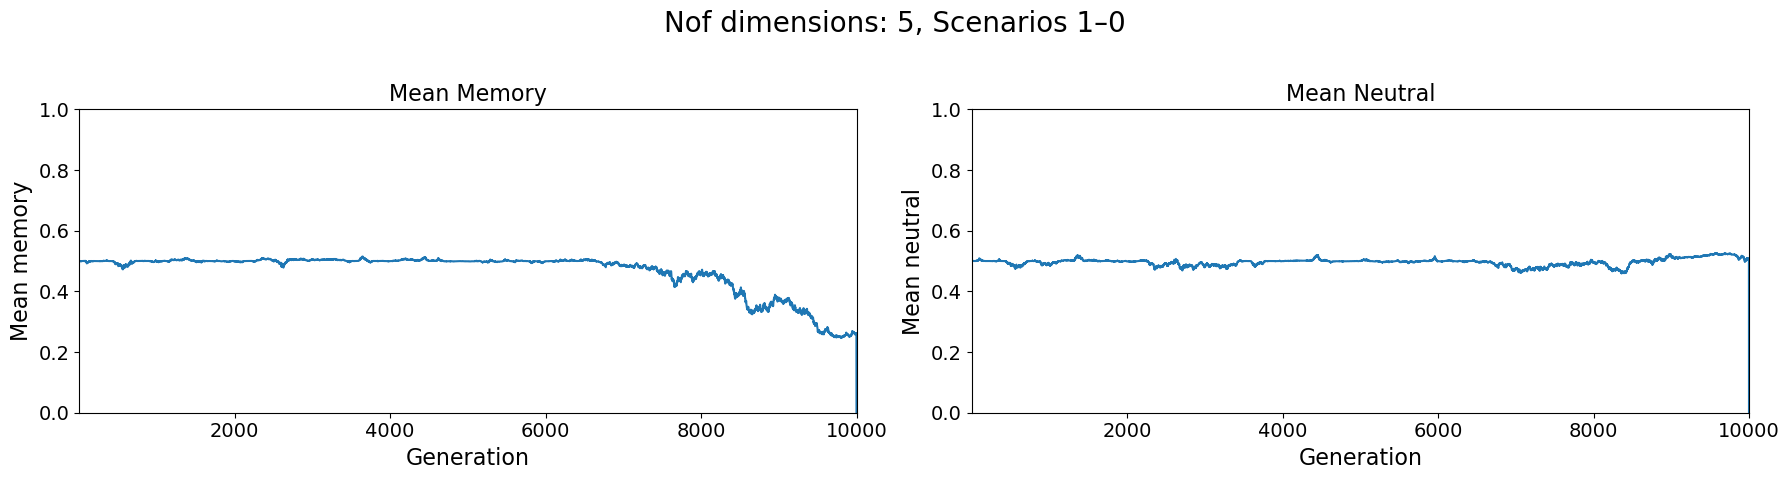

In [93]:
start = 1
concatenated_results = {}

for array in sorted_epi_keys:
    nof_dims = re.findall(r'\d+', array)[0]
   
    # Extract variables
    data = results_array['results_array_5'][0]
    
    meanmemory_p = data['meanmemory_p']
    meanneutral_p = data['meanneutral_p']


   
    maxgen = meanmemory_p.shape[0]

    # Create figure once (outside loop)
    fig, ax = plt.subplots(1, 2, figsize=(18, 5), sharex=True)

   
    # Left plot: mean memory
    ax[0].plot(meanmemory_p)

    # Right plot: mean neutral
    ax[1].plot(meanneutral_p)

    # Add labels, limits, and legends once
    ax[0].set_title("Mean Memory", fontsize =16)
    ax[0].set_ylabel("Mean memory", fontsize =16)
    ax[0].set_xlabel("Generation", fontsize =16)
    ax[0].set_xlim(1, maxgen)
    ax[0].set_ylim(0, 1)

    ax[1].set_title("Mean Neutral", fontsize =16)
    ax[1].set_ylabel("Mean neutral", fontsize =16)
    ax[1].set_xlabel("Generation", fontsize =16)
    ax[1].set_xlim(1, maxgen)
    ax[1].set_ylim(0, 1)
    ax[0].tick_params(axis='both', labelsize=14)
    ax[1].tick_params(axis='both', labelsize=14)

    fig.suptitle(f"Nof dimensions: {nof_dims}, Scenarios {start}–{nof_scenarios - 1}", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


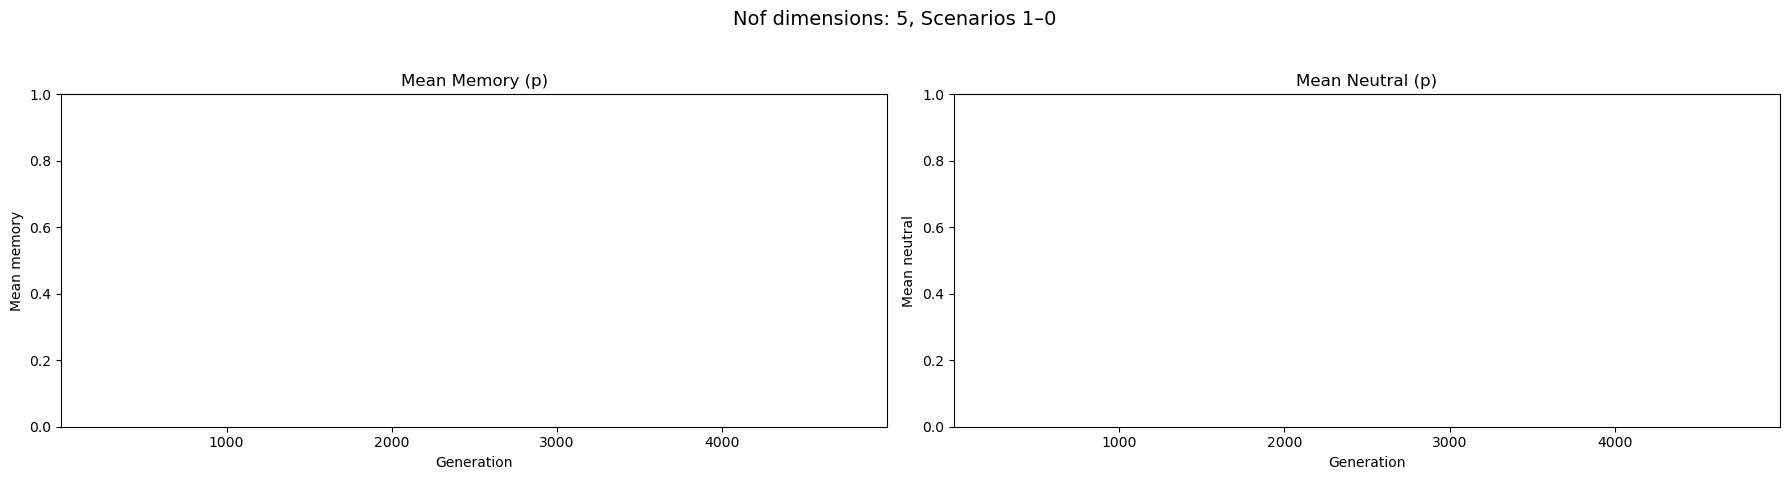

In [68]:

start = 1
concatenated_results = {}

for array in sorted_epi_keys:
    nof_dims = re.findall(r'\d+', array)[0]
    for k in keys:
        concatenated_results[k] = np.vstack([r[k] for r in results_array[array]])
    # Extract variables
    data = concatenated_results
    
    meanmemory_p = data['meanmemory_p'][:, :-1]
    meanneutral_p = data['meanneutral_p'][:, :-1]


    nof_scenarios = meanmemory_p.shape[0]
    maxgen = meanmemory_p.shape[1]

    # Create figure once (outside loop)
    fig, ax = plt.subplots(1, 2, figsize=(18, 5), sharex=True)

    # Loop over scenarios
    for i in range(start, nof_scenarios):  
        # Left plot: mean memory
        ax[0].plot(meanmemory_p[i, :])

        # Right plot: mean neutral
        ax[1].plot(meanneutral_p[i, :])

    # Add labels, limits, and legends once
    ax[0].set_title("Mean Memory (p)")
    ax[0].set_ylabel("Mean memory")
    ax[0].set_xlabel("Generation")
    ax[0].set_xlim(1, maxgen)
    ax[0].set_ylim(0, 1)

    ax[1].set_title("Mean Neutral (p)")
    ax[1].set_ylabel("Mean neutral")
    ax[1].set_xlabel("Generation")
    ax[1].set_xlim(1, maxgen)
    ax[1].set_ylim(0, 1)

    fig.suptitle(f"Nof dimensions: {nof_dims}, Scenarios {start}–{nof_scenarios - 1}", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [ ]:
path= '/home/usriniva/uller_modified/discrete_time/Hanna_simu/results/only_gen'  #neutral folder
#path= '/home/usriniva/uller_modified/discrete_time/Hanna_simu/results/epi'   #epi folder
#------ Different starting point ------

#path = '/home/usriniva/uller_modified/discrete_time/Hanna_simu/results/startingmem_0/only_gen'
#path = '/home/usriniva/uller_modified/discrete_time/Hanna_simu/results/startingmem_0/epi'

#-----long time------
#path= '/home/usriniva/uller_modified/discrete_time/Hanna_simu/results/long_time'

filename=f'/results_dim{nof_dimensions}_og.pkl'
#filename=f'/results_dim{nof_dimensions}.pkl'
tart = 1
concatenated_results = {}

for array in sorted_epi_keys:
    nof_dims = re.findall(r'\d+', array)[0]
    for k in keys:
        concatenated_results[k] = np.vstack([r[k] for r in results_array[array]])
    # Extract variables
    data = concatenated_results
    
    meanmemory_p = data['meanmemory_p'][:, :-1]
    meanneutral_p = data['meanneutral_p'][:, :-1]


    nof_scenarios = meanmemory_p.shape[0]
    maxgen = meanmemory_p.shape[1]

    # Create figure once (outside loop)
    fig, ax = plt.subplots(1, 2, figsize=(18, 5), sharex=True)

    # Loop over scenarios
    for i in range(start, nof_scenarios):  
        # Left plot: mean memory
        ax[0].plot(meanmemory_p[i, :])

        # Right plot: mean neutral
        ax[1].plot(meanneutral_p[i, :])

    # Add labels, limits, and legends once
    ax[0].set_title("Mean Memory (p)")
    ax[0].set_ylabel("Mean memory")
    ax[0].set_xlabel("Generation")
    ax[0].set_xlim(1, maxgen)
    ax[0].set_ylim(0, 1)

    ax[1].set_title("Mean Neutral (p)")
    ax[1].set_ylabel("Mean neutral")
    ax[1].set_xlabel("Generation")
    ax[1].set_xlim(1, maxgen)
    ax[1].set_ylim(0, 1)

    fig.suptitle(f"Nof dimensions: {nof_dims}, Scenarios {start}–{nof_scenarios - 1}", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

#-----

#path='/home/usriniva/uller_modified/discrete_time/Hanna_simu/results/startingmem_0_hi_ss/epi'
#path='/home/usriniva/uller_modified/discrete_time/Hanna_simu/results/startingmem_0_hi_ss/only_gen'

with open(f'{path}/{filename}', 'wb') as f:
    pickle.dump(concatenated_results, f)

In [ ]:
file='/home/usriniva/uller_modified/discrete_time/Hanna_simu/results/long_time/gens10k_0.0001mutrate_0.5start.pkl'

with open(file, 'wb') as f:
    pickle.dump(results_array, f)

In [ ]:
rho_cases = 10
m_cases= 10
maxgen= 10000


full_env_values = create_world(rho_cases, m_cases, maxgen)   # create world (input: generations, no. rhos and no. ms) 
print(full_env_values.shape)

clean_data_env = full_env_values[~np.isnan(full_env_values).any(axis=1)]

In [ ]:
results_array = {}  ### DONT FORGET TO RUN BEFORE NEW PARAM CONDITIONS

popsize = 5000

# Mutation rates: [epi-memory mutation rate, geno mutation rate]
mutrate = [0.0001, 0.0001]

# Mutation sizes: [epi-memory mutation size, geno mutation size]
mutsize = [1, 1]

epsilon = 0.05 # phenotypic noise
                                 
initial_memory = 0.2

# Number of dimensions (can be 1 or more)
nof_dimensions = 10

# get the cube dimensions
dims = get_cube_dims(nof_dimensions)

#create the cube
N = create_cube(popsize, dims=dims, nof_dimensions=nof_dimensions, epsilon=epsilon, initial_memory=initial_memory)

print(N.shape)

if __name__ == '__main__':
    
    # Create all combinations of sigma_mut and sigma_alpha
    param_grid = [
        (scenario, popsize, maxgen, dims, N, mutsize, mutrate, epsilon, nof_dimensions, False) #only genetics can either be True or false
        for _, scenario in enumerate(clean_data_env) #where each row corresponds to one scenario
    ]

    num_cpus = 10
    
    with concurrent.futures.ProcessPoolExecutor(num_cpus) as executor:
        name = f'results_array_{nof_dimensions}' 
        results_array[name] = list(executor.map(run_simulation, param_grid))

In [ ]:
sorted_epi_keys = sorted(results_array.keys(), key=lambda x: int(re.findall(r'\d+', x)[0]))
sorted_epi_keys

# Get all keys 
keys = results_array[sorted_epi_keys[0]][0].keys()
keys

In [ ]:
start = 1
concatenated_results = {}

for array in sorted_epi_keys:
    nof_dims = re.findall(r'\d+', array)[0]
    for k in keys:
        concatenated_results[k] = np.vstack([r[k] for r in results_array[array]])
    # Extract variables
    data = concatenated_results
    
    meanmemory_p = data['meanmemory_p'][:, :-1]
    meanneutral_p = data['meanneutral_p'][:, :-1]


    nof_scenarios = meanmemory_p.shape[0]
    maxgen = meanmemory_p.shape[1]

    # Create figure once (outside loop)
    fig, ax = plt.subplots(1, 2, figsize=(18, 5), sharex=True)

    # Loop over scenarios
    for i in range(start, nof_scenarios):  
        # Left plot: mean memory
        ax[0].plot(meanmemory_p[i, :])

        # Right plot: mean neutral
        ax[1].plot(meanneutral_p[i, :])

    # Add labels, limits, and legends once
    ax[0].set_title("Mean Memory (p)")
    ax[0].set_ylabel("Mean memory")
    ax[0].set_xlabel("Generation")
    ax[0].set_xlim(1, maxgen)
    ax[0].set_ylim(0, 1)

    ax[1].set_title("Mean Neutral (p)")
    ax[1].set_ylabel("Mean neutral")
    ax[1].set_xlabel("Generation")
    ax[1].set_xlim(1, maxgen)
    ax[1].set_ylim(0, 1)

    fig.suptitle(f"Nof dimensions: {nof_dims}, Scenarios {start}–{nof_scenarios - 1}", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [46]:
file='/home/usriniva/uller_modified/discrete_time/Hanna_simu/results/long_time/start0/gens5000_start0_dims10.pkl'

In [48]:
with open(file, "rb") as file:
            results_array = pickle.load(file)

In [44]:
results_array_1 = results_array

In [45]:

results_array ={}
results_array['results_array_10'] = results_array_1

In [49]:
sorted_epi_keys = sorted(results_array.keys(), key=lambda x: int(re.findall(r'\d+', x)[0]))
sorted_epi_keys

['results_array_10']

In [47]:
#results_array = results_array['results_array_10']


with open(file, 'wb') as f:
    pickle.dump(results_array, f)
